In [1]:
!which python

/Users/nihaljayanth/miniconda3/envs/prac/bin/python


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open("data/names.txt", "r").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i for i, s in enumerate(chars, 1)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [5]:
import random
random.seed(42)
random.shuffle(words)

In [6]:
block_size = 8

def build_dataset(words):
    X, y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, ytr = build_dataset(words[:n1])
Xdev, ydev = build_dataset(words[n1:n2])
Xte, yte = build_dataset(words[n2:])

In [7]:
print(len(Xtr), len(ytr))

182625 182625


In [8]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [9]:
# original network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1
#     # layers.layers[-1].weight *= 0.1 # last layer make less confident


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], ytr[ix] # batch X,Y
  
  # forward pass
    # emb = C[Xb]
    # x = emb.view(emb.shape[0], -1)
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

  # loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2985
  10000/ 200000: 2.2871
  20000/ 200000: 2.1615
  30000/ 200000: 1.7439
  40000/ 200000: 1.7811
  50000/ 200000: 1.9823
  60000/ 200000: 1.7761
  70000/ 200000: 1.9819
  80000/ 200000: 2.0921
  90000/ 200000: 1.8356
 100000/ 200000: 1.7248
 110000/ 200000: 1.9990
 120000/ 200000: 1.6358
 130000/ 200000: 2.1713
 140000/ 200000: 1.9762
 150000/ 200000: 1.8555
 160000/ 200000: 2.1628
 170000/ 200000: 1.8221
 180000/ 200000: 1.6584
 190000/ 200000: 1.8027


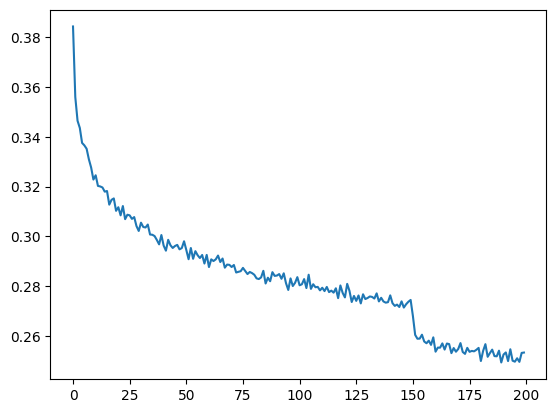

In [11]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [12]:
for layer in model.layers:
    layer.training = False

In [13]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, ytr),
        "val": (Xdev, ydev),
        "test": (Xte, yte),
    }[split]
    # emb = C[x]
    # x = emb.view(emb.shape[0], -1)
    # for layer in layers:
    #     x = layer(x)
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 1.7679905891418457
val 1.9833043813705444


In [14]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        # emb = C[torch.tensor([context])]
        # x = emb.view(emb.shape[0], -1)
        # for layer in layers:
        #     x = layer(x)
        # logits = x
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # logits = model(torch.tensor([context]))
        # probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

kruyann.
vianna.
fletcley.
thian.
damiah.
madilynne.
sovidh.
jacquel.
thumin.
adelina.
mackensie.
kynzie.
lanah.
westlin.
koriyah.
cornan.
ellagrose.
viviana.
whyldo.
hizzam.


In [18]:
60/1.25

48.0

In [38]:
from icecream import ic

In [43]:
def myPow(x: float, n: int) -> float:
    N = n
    if N < 0:
        x = 1 / x
        N = -N
    res = 1.0
    while N > 0:
        ic(N)
        if N & 1:
            res *= x
        x *= x
        N >>= 1
        ic(x)
        ic(res)
    return res

In [48]:
myPow(3,5)

ic| N: 5
ic| x: 9
ic| res: 3.0
ic| N: 2
ic| x: 81
ic| res: 3.0
ic| N: 1
ic| x: 6561
ic| res: 243.0


243.0

In [53]:
bin(5)

'0b101'

In [51]:
27*3

81

In [45]:
from math import log2

In [47]:
log2(8)

3.0

In [ ]:
#log 2 8 = 3
